In [1]:
pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import os
from fastai.vision.all import *
from nbdev.showdoc import *
import fastbook
fastbook.setup_book()
import random
from fastai.vision.augment import aug_transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from fastai.data.load import DataLoader
from imblearn.over_sampling import RandomOverSampler

2024-05-28 10:29:24.168555: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 10:29:24.232782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 10:29:25.178381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import cv2
import numpy as np
from fastai.vision.all import *



In [3]:
import math
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [4]:
class OtsuThreshold(Transform):
    def encodes(self, x:TensorImage):
        img = x.squeeze().cpu().numpy()  # Convertir el tensor de imagen a una matriz numpy
        op_thres = get_optimal_threshold(img)
        return TensorImage(regenerate_img(img, op_thres))

def Hist(img):
    y = np.zeros(256)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            y[img[i,j]] += 1
    x = np.arange(0,256)
    plt.bar(x, y, color='b', width=5, align='center', alpha=0.25)
    plt.show()
    return y

def countPixel(h):
    cnt = 0
    for i in range(len(h)):
        if h[i] > 0:
           cnt += h[i]
    return cnt

def wieght(s, e, h):
    w = 0
    for i in range(s, e):
        w += h[i]
    return w

def mean(s, e, h):
    m = 0
    w = wieght(s, e, h)
    for i in range(s, e):
        m += h[i] * i
    return m / float(w)

def variance(s, e, h):
    v = 0
    m = mean(s, e, h)
    w = wieght(s, e, h)
    for i in range(s, e):
        v += ((i - m) **2) * h[i]
    v /= w
    return v

def threshold(h):
    threshold_values = {}  # Inicializar el diccionario
    cnt = countPixel(h)
    for i in range(1, len(h)):
        vb = variance(0, i, h)
        wb = wieght(0, i, h) / float(cnt)
        mb = mean(0, i, h)
        
        vf = variance(i, len(h), h)
        wf = wieght(i, len(h), h) / float(cnt)
        mf = mean(i, len(h), h)
        
        V2w = wb * (vb) + wf * (vf)
        V2b = wb * wf * (mb - mf)**2
        
        if not math.isnan(V2w):
            threshold_values[i] = V2w
    return threshold_values

def get_optimal_threshold(h):
    threshold_values = threshold(h)
    min_V2w = min(threshold_values.values())
    optimal_threshold = [k for k, v in threshold_values.items() if v == min_V2w]
    return optimal_threshold[0]

def regenerate_img(img, threshold):
    y = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] >= threshold:
                y[i,j] = 255
            else:
                y[i,j] = 0
    return y

In [5]:
def otsuThresholding(img: np.ndarray) -> np.ndarray:
    threshold_range = range(np.max(img) + 1)
    criterias = np.array([_compute_otsu_criteria(img, th) for th in threshold_range])

    # Mejor umbral es el que minimiza el criterio de Otsu
    best_threshold = threshold_range[np.argmin(criterias)]

    binary = img
    binary[binary > best_threshold] = 255
    binary[binary <= best_threshold] = 0

    return binary

In [6]:
def _compute_otsu_criteria(img: np.ndarray, threshold: int) -> float:
    """
    Compute Otsu's criteria for a given threshold.
    """
    hist = np.bincount(img.ravel(), minlength=256)
    total_pixels = img.size

    # compute probabilities
    w0 = np.cumsum(hist)  # P1
    w1 = total_pixels - w0  # P2
    mu0 = np.cumsum(hist * np.arange(256)) / (w0 + np.finfo(float).eps)  # mu1
    mu1 = (np.cumsum(hist[::-1] * np.arange(256)[::-1]) / (w1[::-1] + np.finfo(float).eps))[::-1]  # mu2

    # compute inter-class variance
    criteria = w0[:-1] * w1[:-1] * (mu0[:-1] - mu1[:-1]) ** 2

    return np.sum(criteria)

In [11]:
bac_minus_folder = 'NEGATIVOS'
bac_plus_folder = 'POSITIVOS'

bac_minus_paths = get_image_files(bac_minus_folder)
bac_plus_paths = get_image_files(bac_plus_folder)

bac_minus_labels = [0] * len(bac_minus_paths)
bac_plus_labels = [1] * len(bac_plus_paths)

all_paths = list(bac_minus_paths) + list(bac_plus_paths)
all_labels = bac_minus_labels + bac_plus_labels

train_paths, valid_paths, train_labels, valid_labels = train_test_split(all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

train_df = pd.DataFrame({'image_path': train_paths, 'label': train_labels})
valid_df = pd.DataFrame({'image_path': valid_paths, 'label': valid_labels})



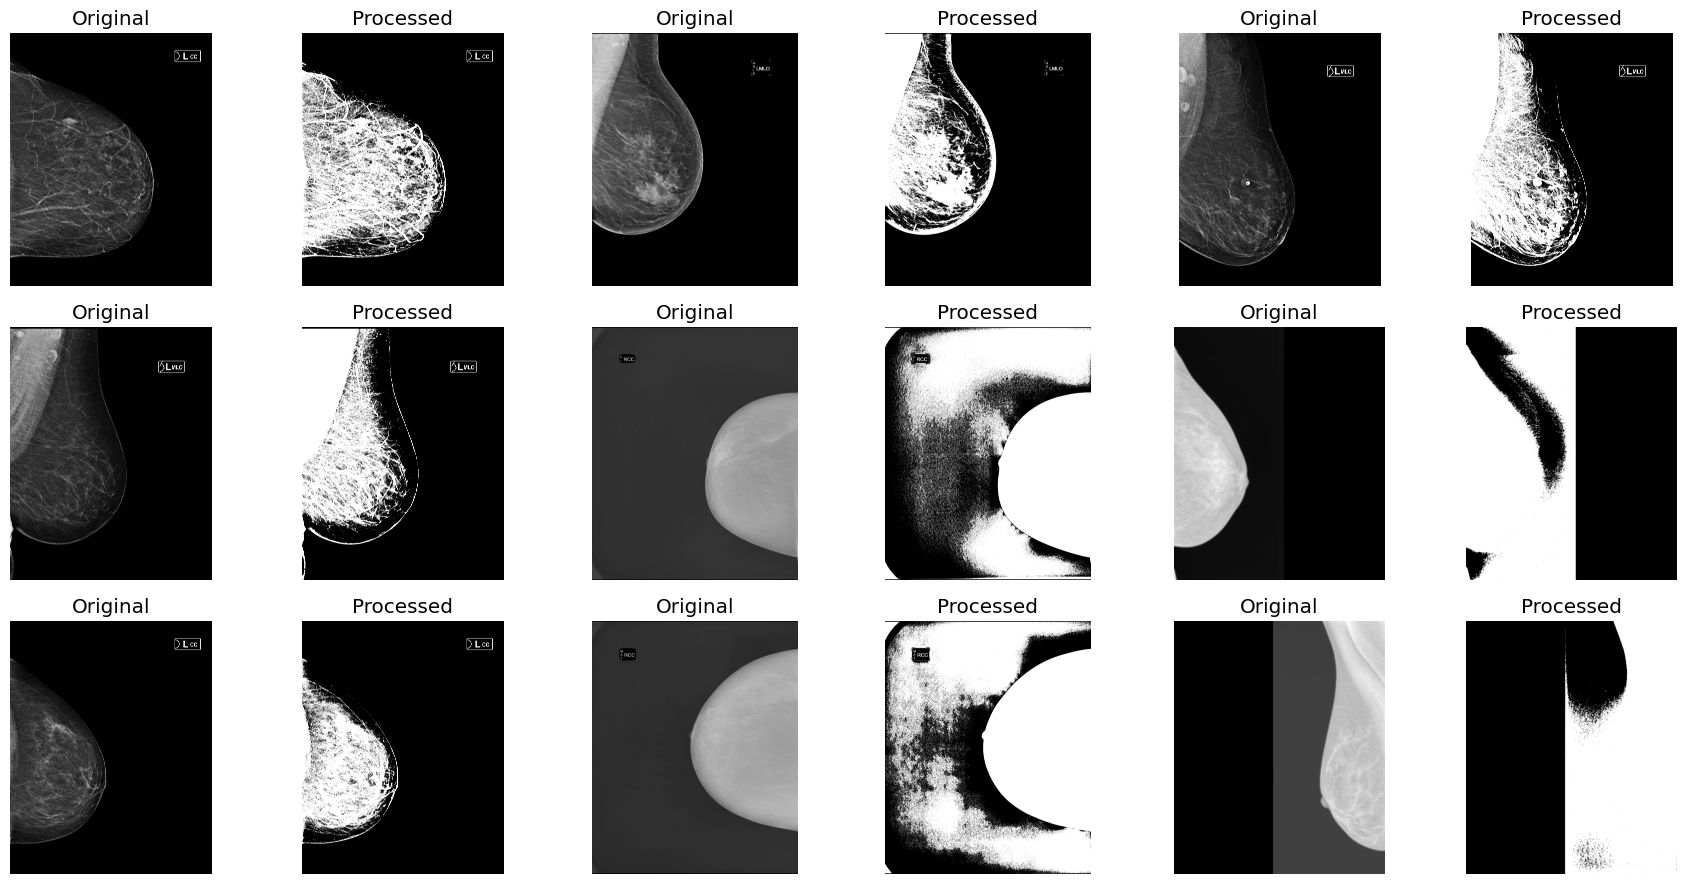

In [14]:
import cv2

random_indices = np.random.randint(0, len(train_df), size=9)
sample_images = train_df.iloc[random_indices]


def preprocess_image(img: np.ndarray) -> np.ndarray:
    # Aplicar filtrado para mejorar el contraste
    img = cv2.equalizeHist(img)
    # Aplicar umbral adaptativo
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

# Función para mostrar imágenes antes y después del procesamiento
def plot_images_with_preprocessing(sample_images):
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))

    for i, (_, row) in enumerate(sample_images.iterrows()):
        # Verifica que image_path sea una cadena antes de cargar la imagen
        image_path = str(row['image_path'])
        if os.path.exists(image_path):  # Verifica si la ruta del archivo existe
            # Carga y muestra la imagen original
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            axes[i // 3, 2 * (i % 3)].imshow(image, cmap='gray')
            axes[i // 3, 2 * (i % 3)].set_title('Original')
            axes[i // 3, 2 * (i % 3)].axis('off')

            # Aplica preprocesamiento y muestra la imagen resultante
            processed_img = preprocess_image(image)
            axes[i // 3, 2 * (i % 3) + 1].imshow(processed_img, cmap='gray')
            axes[i // 3, 2 * (i % 3) + 1].set_title('Processed')
            axes[i // 3, 2 * (i % 3) + 1].axis('off')
        else:
            print(f"File not found: {image_path}")

    plt.tight_layout()
    plt.show()

# Muestra las imágenes con preprocesamiento
plot_images_with_preprocessing(sample_images)


In [8]:
import matplotlib.pyplot as plt
from PIL import Image

# Selecciona 9 imágenes aleatorias del conjunto de datos
random_indices = np.random.randint(0, len(train_df), size=9)
sample_images = train_df.iloc[random_indices]

# Define una función para mostrar las imágenes antes y después de la transformación de Otsu
def plot_images_with_otsu(sample_images):
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))

    for i, (_, row) in enumerate(sample_images.iterrows()):
        # Carga y muestra la imagen original
        image_path = row['image_path']
        image = Image.open(image_path)
        axes[i // 3, 2 * (i % 3)].imshow(image)
        axes[i // 3, 2 * (i % 3)].set_title('Original')
        axes[i // 3, 2 * (i % 3)].axis('off')

        # Aplica la transformación de Otsu y muestra la imagen resultante
        img = np.array(image.convert('L'))  # Convierte a escala de grises
        otsu_img = otsuThresholding(img)
        axes[i // 3, 2 * (i % 3) + 1].imshow(otsu_img, cmap='gray')
        axes[i // 3, 2 * (i % 3) + 1].set_title('Otsu Thresholding')
        axes[i // 3, 2 * (i % 3) + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Muestra las imágenes


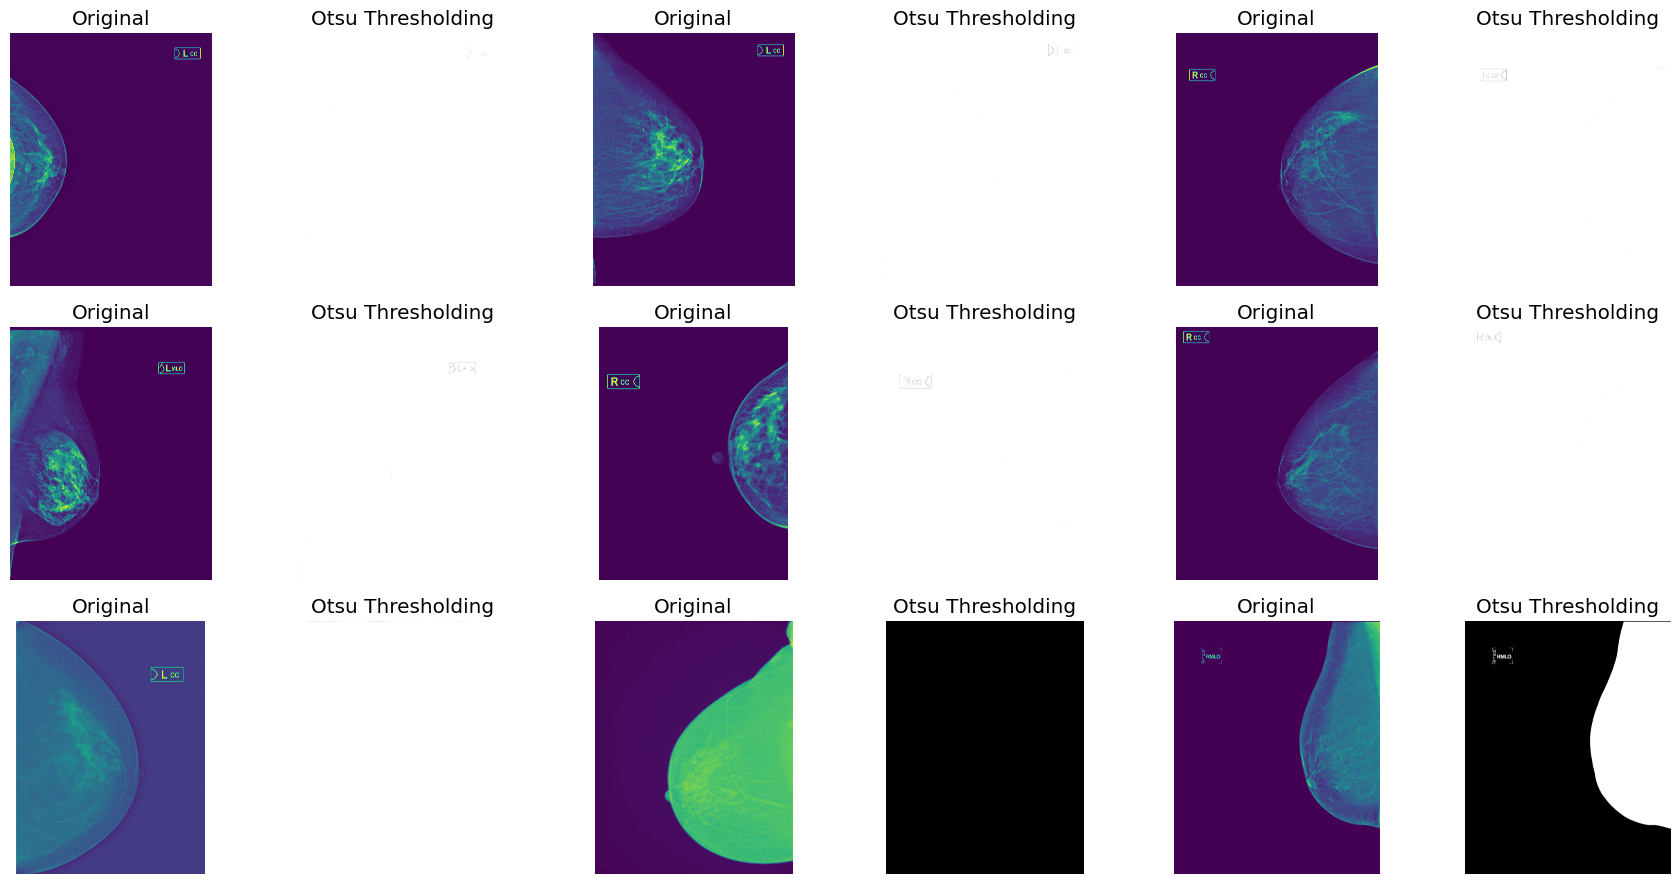

In [9]:
plot_images_with_otsu(sample_images)


In [7]:
def otsuThresholding(img: np.ndarray) -> np.ndarray:
    threshold_range = range(np.max(img) + 1)
    criterias = np.array([_compute_otsu_criteria(img, th) for th in threshold_range])

    # Mejor umbral es el que minimiza el criterio de Otsu
    best_threshold = threshold_range[np.argmin(criterias)]

    binary = img.copy()  # Crea una copia de la imagen para evitar modificar la original
    binary[binary > best_threshold] = 255
    binary[binary <= best_threshold] = 0

    return binary

def _compute_otsu_criteria(img: np.ndarray, threshold: int) -> float:
    """
    Compute Otsu's criteria for a given threshold.
    """
    hist = np.bincount(img.ravel(), minlength=256)
    total_pixels = img.size

    # compute probabilities
    w0 = np.cumsum(hist)  # P1
    w1 = total_pixels - w0  # P2
    mu0 = np.cumsum(hist * np.arange(256)) / (w0 + np.finfo(float).eps)  # mu1
    mu1 = (np.cumsum(hist[::-1] * np.arange(256)[::-1]) / (w1[::-1] + np.finfo(float).eps))[::-1]  # mu2

    # compute inter-class variance
    criteria = w0[:-1] * w1[:-1] * (mu0[:-1] - mu1[:-1]) ** 2

    return np.sum(criteria)


In [8]:
bac_minus_folder = 'NEGATIVOS'
bac_plus_folder = 'POSITIVOS'

bac_minus_paths = get_image_files(bac_minus_folder)
bac_plus_paths = get_image_files(bac_plus_folder)

bac_minus_labels = [0] * len(bac_minus_paths)
bac_plus_labels = [1] * len(bac_plus_paths)

all_paths = list(bac_minus_paths) + list(bac_plus_paths)
all_labels = bac_minus_labels + bac_plus_labels

train_paths, valid_paths, train_labels, valid_labels = train_test_split(all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

train_df = pd.DataFrame({'image_path': train_paths, 'label': train_labels})
valid_df = pd.DataFrame({'image_path': valid_paths, 'label': valid_labels})



In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Selecciona 9 imágenes aleatorias del conjunto de datos
random_indices = np.random.randint(0, len(train_df), size=9)
sample_images = train_df.iloc[random_indices]

# Define una función para mostrar las imágenes antes y después de la transformación de Otsu
def plot_images_with_otsu(sample_images):
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))

    for i, (_, row) in enumerate(sample_images.iterrows()):
        # Carga y muestra la imagen original
        image_path = row['image_path']
        image = Image.open(image_path)
        axes[i // 3, 2 * (i % 3)].imshow(image)
        axes[i // 3, 2 * (i % 3)].set_title('Original')
        axes[i // 3, 2 * (i % 3)].axis('off')

        # Aplica la transformación de Otsu y muestra la imagen resultante
        img = np.array(image.convert('L'))  # Convierte a escala de grises
        otsu_img = otsuThresholding(img)
        axes[i // 3, 2 * (i % 3) + 1].imshow(otsu_img, cmap='gray')
        axes[i // 3, 2 * (i % 3) + 1].set_title('Otsu Thresholding')
        axes[i // 3, 2 * (i % 3) + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Muestra las imágenes


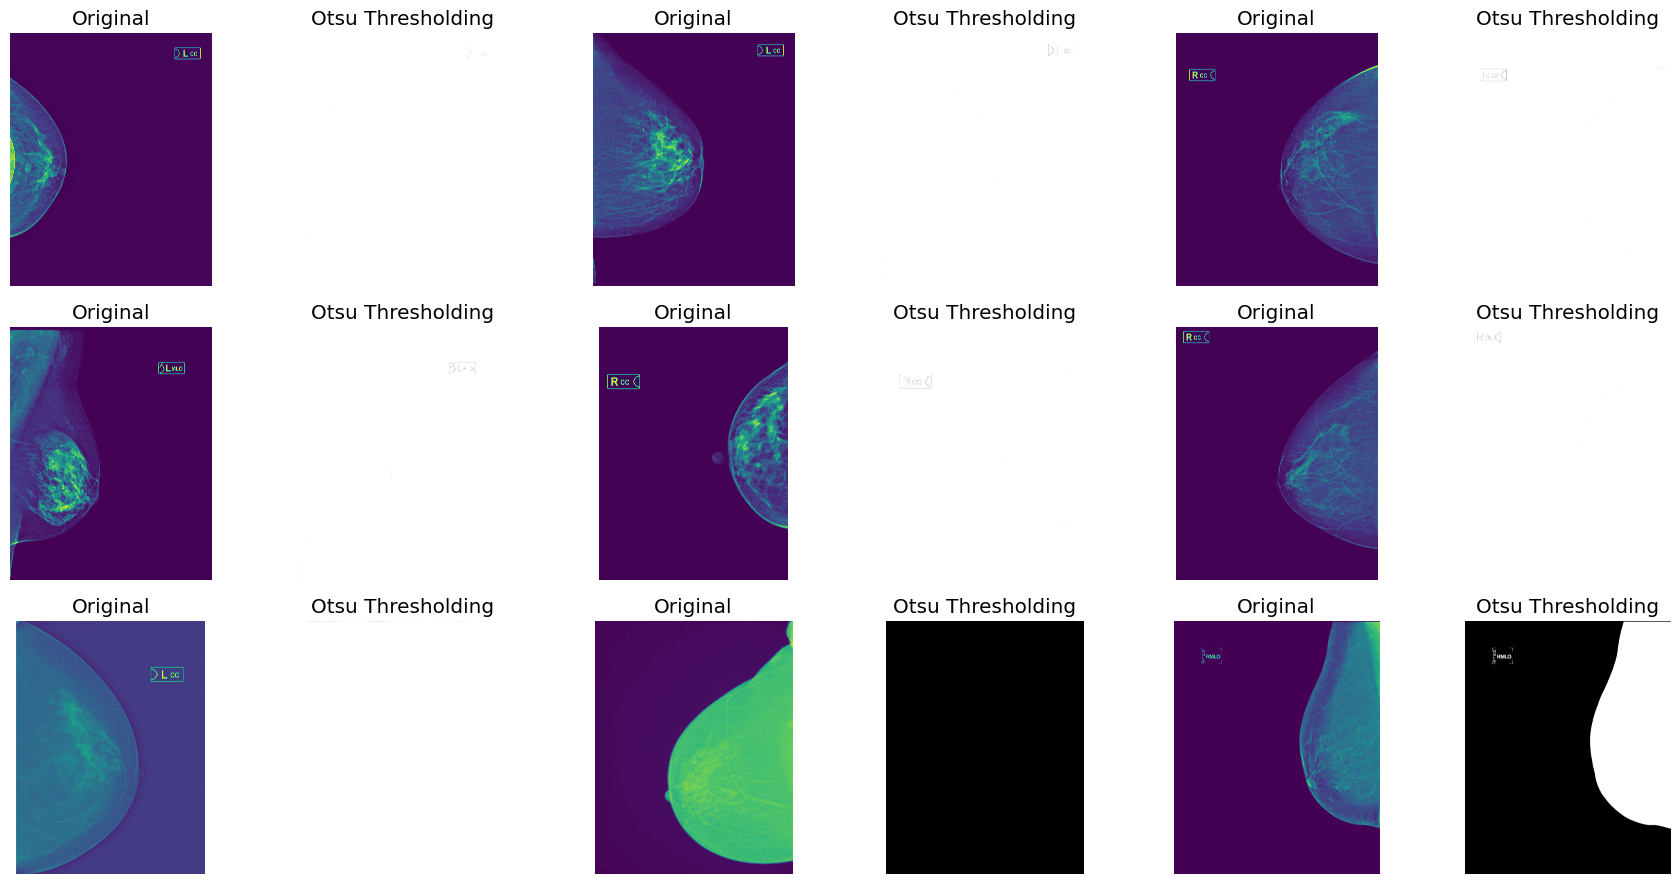

In [10]:
plot_images_with_otsu(sample_images)


In [11]:
import random
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(train_df)), 9)
random_images = [train_df.iloc[idx]['image_path'] for idx in random_indices]

# Crea una figura
fig = plt.figure(figsize=(18, 9))

# Itera sobre las imágenes seleccionadas
for i, img_path in enumerate(random_images, 1):
    # Carga la imagen original
    original_img = Image.open(img_path)
    # Carga la imagen binarizada con Otsu
    otsu_img = otsuThresholding(np.asarray(original_img))

    # Añade un subplot para la imagen original
    ax1 = fig.add_subplot(3, 6, 2*i - 1)
    ax1.imshow(original_img)
    ax1.set_title('Original')
    ax1.axis('off')

    # Añade un subplot para la imagen binarizada con Otsu
    ax2 = fig.add_subplot(3, 6, 2*i)
    ax2.imshow(otsu_img, cmap='gray')
    ax2.set_title('Otsu Thresholding')
    ax2.axis('off')

# Ajusta el espacio entre subplots y muestra la figura
plt.tight_layout()
plt.show()

ValueError: assignment destination is read-only

<Figure size 1800x900 with 0 Axes>

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image_path'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(512),
    batch_tfms=[*aug_transforms(flip_vert=False, do_flip=False), otsuThresholding]
)

dls = dblock.dataloaders(pd.concat([train_df, valid_df]))

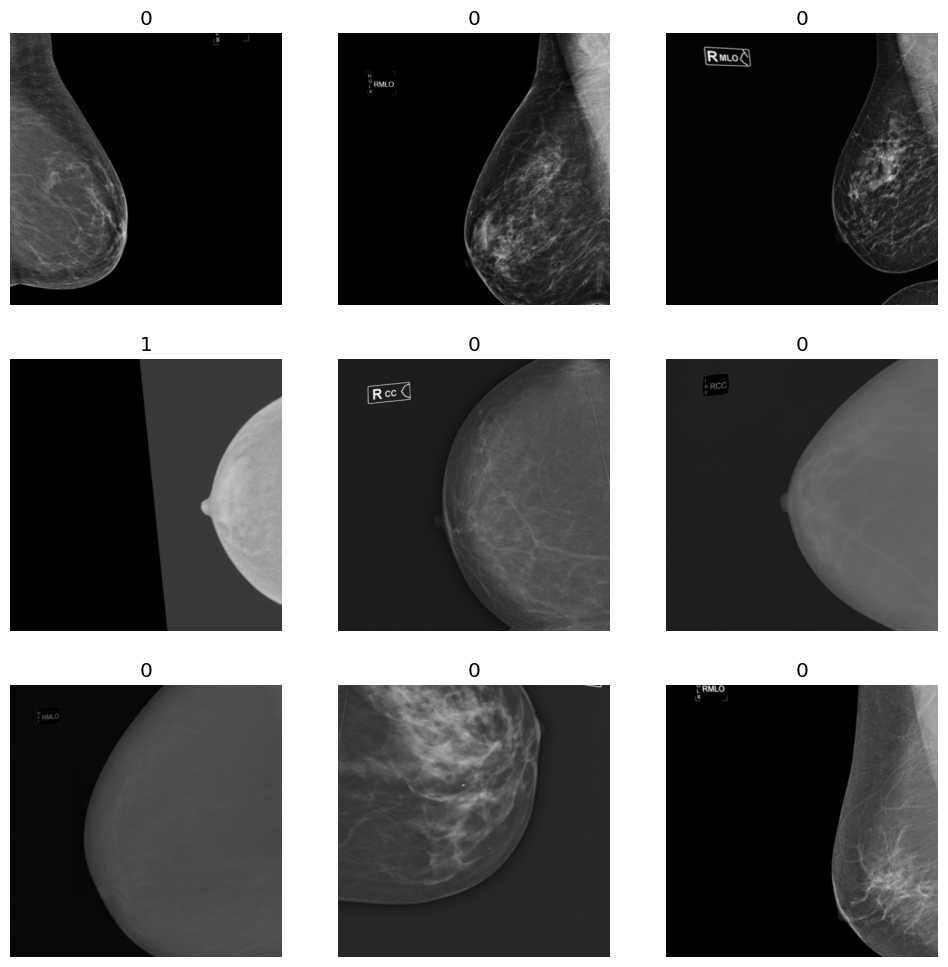

In [20]:
dls.show_batch(max_n=9, figsize=(12, 12))